In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import compress
from nltk import pos_tag
from nltk.corpus import wordnet, stopwords
from nltk.stem import snowball, WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer 
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split 
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.pipeline import make_pipeline, make_union
from sklearn import svm
from sklearn.feature_selection import SelectKBest, SelectPercentile, chi2, f_classif
import warnings
warnings.filterwarnings('ignore')

In [2]:
# load data
file_name = "Isla Vista - All Excerpts - 1_2_2019.xlsx"
data = pd.read_excel(file_name, sheet_name='Dedoose Excerpts Export')
print(data.shape)
data = data.dropna(axis=0)
print(data.shape)
print(data.columns)

(8131, 53)
(8127, 53)
Index(['StoryID', 'Excerpt', 'CodesApplied_Combined', 'ACCOUNT',
       'ACCOUNT_Cultural', 'ACCOUNT_Individual', 'ACCOUNT_Other',
       'COMMUNITYRECOVERY', 'EVENT', 'GRIEF', 'GRIEF_Individual',
       'GRIEF_Community', 'GRIEF_Societal', 'HERO', 'INVESTIGATION', 'JOURNEY',
       'JOURNEY_Mental', 'JOURNEY_Physical', 'LEGAL', 'MEDIA', 'MISCELLANEOUS',
       'MOURNING', 'MOURNING_Individual', 'MOURNING_Community',
       'MOURNING_Societal', 'PERPETRATOR', 'PHOTO', 'POLICY', 'POLICY_Guns',
       'POLICY_InfoSharing', 'POLICY_MentalHealth', 'POLICY_Other',
       'POLICY_VictimAdv', 'POLICY_OtherAdv', 'POLICY_Practice',
       'PRIVATESECTOR', 'RACECULTURE', 'RESOURCES', 'SAFETY',
       'SAFETY_Community', 'SAFETY_Individual', 'SAFETY_SchoolOrg',
       'SAFETY_Societal', 'SOCIALSUPPORT', 'THREAT', 'THREAT_Assessment',
       'TRAUMA', 'TRAUMA_Physical', 'TRAUMA_Psychological',
       'TRAUMA_Individual', 'TRAUMA_Community', 'TRAUMA_Societal', 'VICTIMS'],
    

In [3]:
excerpts = list(data['Excerpt'])
def stem_tokenizer(doc):
    tokens = word_tokenize(doc) 
    stemmer = snowball.SnowballStemmer("english")
    stemmed_tokens = [stemmer.stem(word) for word in tokens]
    list_tokens = [tok.lower() for tok in stemmed_tokens if tok.isalpha()]
    return(' '.join(list_tokens))
print("original: "+str(excerpts[3]))
print(stem_tokenizer(excerpts[3]))

original: A 22-year-old student last Friday killed six people and wounded 13 more in Isla Vista before turning his gun on himself. Commenters 
blamed the killer�s crimes on everything from misogynistic �pickup artist philosophy� to easy access to guns and no-fault divorce. Even 
�nerd culture� has come under scrutiny. 

Is American culture to blame for mass murder? 
a student last friday kill six peopl and wound more in isla vista before turn his gun on himself comment blame the crime on everyth from misogynist artist to easi access to gun and divorc even has come under scrutini is american cultur to blame for mass murder


In [4]:
# stem + count
docs = [stem_tokenizer(doc) for doc in excerpts]
vectorizer = CountVectorizer(max_features=1500, min_df=5, max_df=0.7, 
                             stop_words=stopwords.words('english'))  
stem_count_X = vectorizer.fit_transform(docs).toarray() 

In [44]:
doc_id = 10
print("Doc: "+str(docs[doc_id]))
feat_names = vectorizer.get_feature_names()
for idx, val in enumerate(list(stem_count_X[doc_id])):
    if val >0:
        print(str(val)+ " "+str(feat_names[idx]))
        if feat_names[idx] not in docs[doc_id]:
            print("missing feat")

Doc: richard martinez has a messag for the politician who have been call to express condol on the death of his son christoph in the massacr of six peopl in isla vista on friday do care about your sympathi he said to work and do someth through his tear he call lawmak in washington rudderless bunch of idiot for bow to the nation rifl associ and refus to enact restrict that might have kept three semiautomat handgun away from the derang shooter elliot rodger peopl are get rich sit in congress he said what do they do they do take care of our kid
1 associ
1 away
2 call
2 care
1 christoph
1 condol
1 congress
1 death
1 derang
1 elliot
1 express
1 friday
1 get
1 handgun
1 isla
1 kept
1 kid
1 lawmak
1 martinez
1 massacr
1 messag
1 might
1 nation
2 peopl
1 politician
1 refus
1 richard
1 rifl
1 rodger
2 said
1 semiautomat
1 shooter
1 sit
1 six
1 someth
1 son
1 sympathi
1 take
1 tear
1 three
1 vista
1 washington
1 work


In [50]:
data_df = pd.DataFrame(stem_count_X)
data_df.columns = vectorizer.get_feature_names()
data_df.head()

,ab,abil,abl,academ,acceler,accept,access,accomplish,accord,account,...,yang,year,yes,yesallwomen,yet,york,young,younger,youtub,yuan
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [62]:
y = data.ACCOUNT
X_indices = np.arange(stem_count_X.shape[-1])
#selector = SelectPercentile(f_classif, percentile=0.1)
selector = SelectKBest(chi2, k=100)
X_new = selector.fit_transform(data_df, y)
print(list(compress(data_df.columns, selector.get_support())))

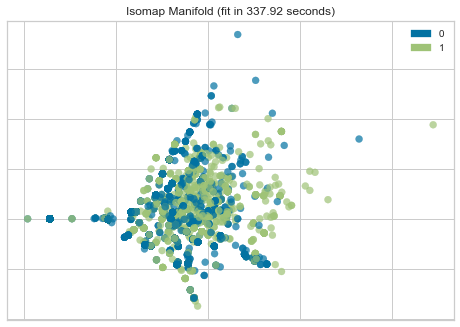

In [53]:
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from yellowbrick.features.manifold import Manifold

model = Pipeline([
    ("selectk", SelectKBest(k=10, score_func=f_classif)),
    ("viz", Manifold(manifold='isomap', target='discrete')),
])


# Extract the instances and target
X = data_df
y = data.ACCOUNT

model.fit(X, y)
model.named_steps['viz'].poof()

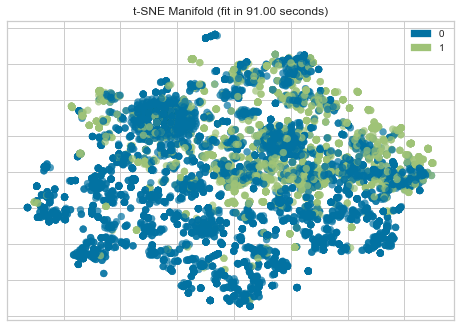

In [54]:
model = Pipeline([
    ("selectk", SelectKBest(k=100, score_func=f_classif)),
    ("viz", Manifold(manifold='tsne', target='discrete')),
])

model.fit(X, y)
model.named_steps['viz'].poof()